In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../src")

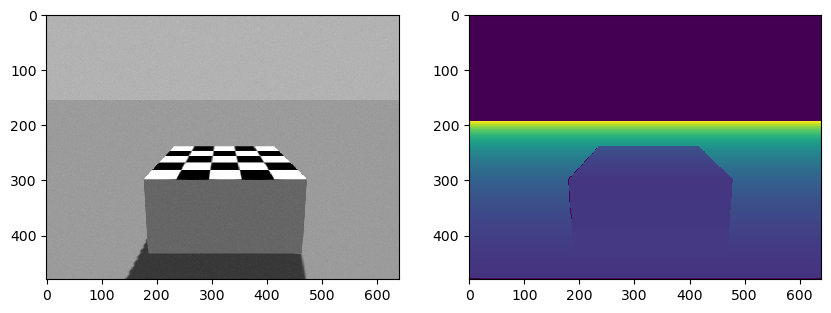

In [2]:
from camera import (
    move_camera_pos,
    get_model_state,
    get_camera_info,
    get_camera_image_rgb,
    get_camera_image_depth,
)
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rospy

rospy.init_node("camera_test")

# current default as of 2023-01-18
move_camera_pos(-2, 0, 1, pitch=0.2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(get_camera_image_rgb())
ax[1].imshow(get_camera_image_depth())
plt.show()

In [3]:
# NOTE: if we try to get the corners using the default perspective, we fail
move_camera_pos(-2, 0, 1, pitch=0.2)
rgb = get_camera_image_rgb()
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (4, 4), None)
ret, corners

(False, None)

So it turns out that there are some weird things to consider when using `cv2.findChessboardCorners()`.

- https://stackoverflow.com/questions/17665912/findchessboardcorners-fails-for-calibration-image
- https://stackoverflow.com/questions/19190484/what-is-the-opencv-findchessboardcorners-convention

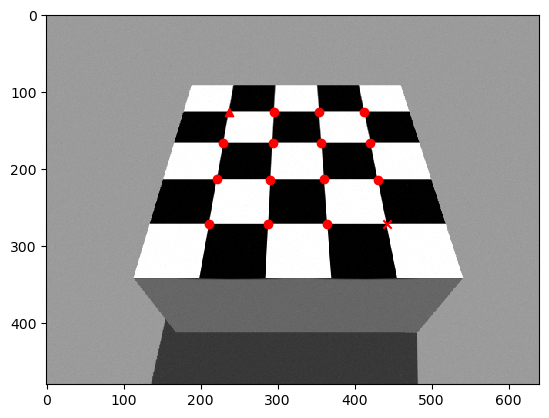

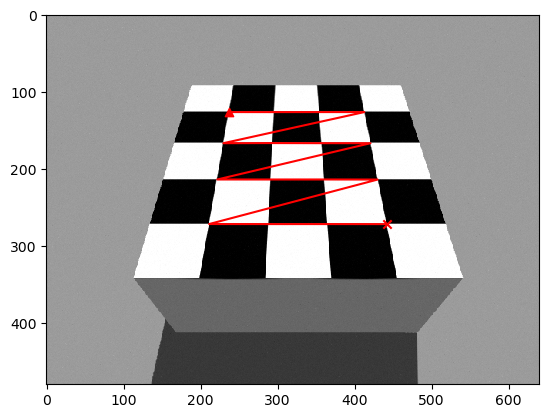

(16, 2)

In [4]:
move_camera_pos(-1, 0, 1.5, pitch=0.9)
rgb = get_camera_image_rgb()

# let's try to get the chessboard corners
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (4, 4), None)
# delete axis 1
corners = corners.squeeze(1)

# we found corners, so let's just draw them using a scatter plot
plt.imshow(rgb)
plt.scatter(corners[1:-1, 0], corners[1:-1, 1], c="r")
plt.scatter(corners[0, 0], corners[0, 1], c="r", marker="^")
plt.scatter(corners[-1, 0], corners[-1, 1], c="r", marker="x")
plt.show()

plt.imshow(rgb)
plt.scatter(corners[0, 0], corners[0, 1], c="r", marker="^")
plt.scatter(corners[-1, 0], corners[-1, 1], c="r", marker="x")
plt.plot(corners[:, 0], corners[:, 1], c="r")
plt.show()

corners.shape

Let's perform DLT with this data now and see what we get.
The the top left corner will be our origin.
In order to recover the depth, we'll need to map the pixel coordinate to the depth image.
We'll use a simple linear interpolation to do this.

In [20]:
corners

array([[236.57909, 125.98114],
       [295.39444, 126.02252],
       [353.9935 , 125.99535],
       [412.42776, 125.98468],
       [229.41882, 166.40312],
       [293.25427, 166.24196],
       [356.56924, 166.3571 ],
       [420.45383, 166.4138 ],
       [221.53893, 213.54463],
       [290.45108, 213.55775],
       [360.46368, 213.52376],
       [429.7019 , 213.6194 ],
       [210.94415, 271.40182],
       [287.55173, 271.4482 ],
       [364.56915, 271.43265],
       [441.59338, 271.48898]], dtype=float32)

In [42]:
depth = get_camera_image_depth()
print(depth.shape)

depths = []
for corner in corners:
    x, y = corner
    # get all 4 points, and then do a weighted average
    x_floor, x_ceil = int(np.floor(x)), int(np.ceil(x))
    y_floor, y_ceil = int(np.floor(y)), int(np.ceil(y))
    values = [
        depth[y_floor, x_floor],
        depth[y_floor, x_ceil],
        depth[y_ceil, x_floor],
        depth[y_ceil, x_ceil],
    ]
    # for linear interpolation, we want to know how far we are from the
    # fractional point using euclidean distance
    weights = [
        np.linalg.norm([x - x_floor, y - y_floor]),
        np.linalg.norm([x - x_ceil, y - y_floor]),
        np.linalg.norm([x - x_floor, y - y_ceil]),
        np.linalg.norm([x - x_ceil, y - y_ceil]),
    ]
    # weighted average gives us a depth value
    depths.append(np.average(values, weights=weights))

depths = np.array(depths)
corner_depth = np.concatenate([corners, depths[:, None]], axis=1)
corner_depth

(480, 640)


array([[ 236.5790863 ,  125.98114014, 1578.44008149],
       [ 295.3944397 ,  126.02252197, 1573.62469146],
       [ 353.99349976,  125.9953537 , 1578.52859317],
       [ 412.42776489,  125.98468018, 1578.44304766],
       [ 229.41882324,  166.40312195, 1450.90401598],
       [ 293.25427246,  166.24195862, 1450.75719165],
       [ 356.56924438,  166.35710144, 1450.85997184],
       [ 420.4538269 ,  166.4138031 , 1450.91443893],
       [ 221.53892517,  213.54463196, 1328.04454338],
       [ 290.45108032,  213.55775452, 1328.05756304],
       [ 360.46368408,  213.52375793, 1328.02374451],
       [ 429.7019043 ,  213.61940002, 1328.11758256],
       [ 210.94415283,  271.40182495, 1203.45449915],
       [ 287.55172729,  271.44821167, 1203.47417491],
       [ 364.56915283,  271.43264771, 1203.46647525],
       [ 441.59338379,  271.48898315, 1203.49449306]])

In [43]:
# assign each point in a 4x4 grid a value between 0 and 100
points = []
n_grid = 4
height = 0.5
length = 1 / n_grid
for j in range(n_grid):
    for i in range(n_grid):
        points.append((i * length, j * length, height))
points = np.array(points)
points.shape

(16, 3)

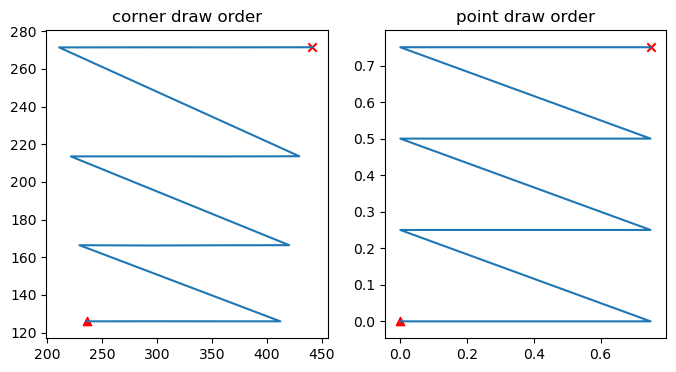

In [44]:
# 1x2 plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

x = corners
ax[0].plot(x[:, 0], x[:, 1])
ax[0].scatter(x[0, 0], x[0, 1], c="r", marker="^")
ax[0].scatter(x[-1, 0], x[-1, 1], c="r", marker="x")
ax[0].set_title("corner draw order")

x = points
ax[1].plot(x[:, 0], x[:, 1])
ax[1].scatter(x[0, 0], x[0, 1], c="r", marker="^")
ax[1].scatter(x[-1, 0], x[-1, 1], c="r", marker="x")
ax[1].set_title("point draw order")
plt.show()

We use the following equation to map the points.

- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:bali_3d_reconstruction_using_dlt.pdf
- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:ece4580_t03_calibration.pdf

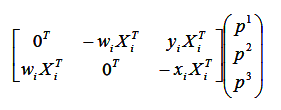

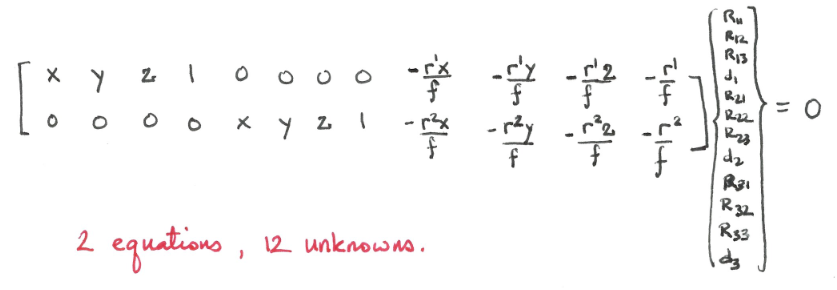

We'll do this the brute force way first, and then figure out how to vectorize it later.

In [47]:
A = []
for corner, point in zip(corner_depth, points):
    x, y, w = corner
    X = np.hstack([point, 1])
    A += [
        np.hstack([np.zeros(4), -w * X, y * X]),
        np.hstack([w * X, np.zeros(4), -x * X]),
    ]

A = np.array(A)
print(A.shape)

# perform SVD, and get the last right singular vector as the projection matrix
U, s, V = np.linalg.svd(A)
P = V[-1].reshape(3, 4)
P

(32, 12)


array([[-0.00000000e+00,  3.50454029e-17, -5.92140127e-05,
         2.96070064e-05],
       [ 5.98005261e-19,  8.18233827e-18, -4.03081538e-04,
         2.01540769e-04],
       [-1.19170152e-17, -1.74842325e-17,  8.94427098e-01,
        -4.47213549e-01]])

Let's verify the results.
If we sample any point on the chessboard, we should get a uniform depth value.
Any point outside of the table should be at a depth of 0.

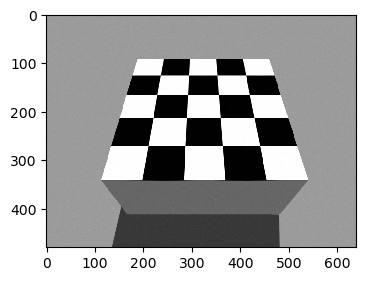

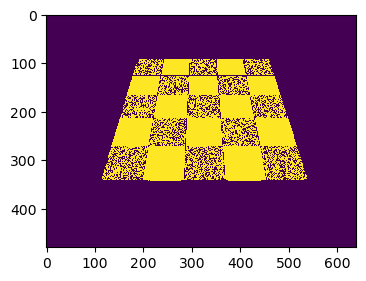

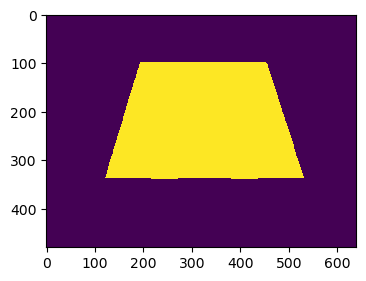

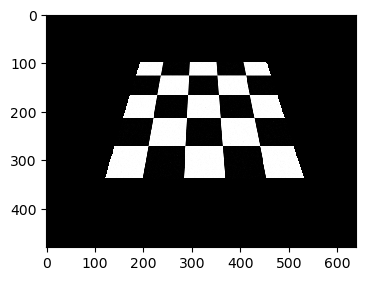

In [91]:
# show on a smaller figure
plt.figure(figsize=(4, 4))
plt.imshow(rgb)
plt.show()

# find all points that are close to pure black or pure white
threshold = 100
mask = np.logical_or(
    np.abs(rgb - 255).sum(axis=2) < threshold,
    np.abs(rgb - 0).sum(axis=2) < threshold,
)
plt.figure(figsize=(4, 4))
plt.imshow(mask)
plt.show()

# now lets dilate this mask to fill in the gaps, and then erode it to only get
# points inside of the table
kernel = np.ones((3, 3), np.uint8)
mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=5)
mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=10)
plt.figure(figsize=(4, 4))
plt.imshow(mask)
plt.show()

# now use the mask and apply it on the image
rgb_masked = rgb.copy()
rgb_masked = rgb_masked * mask[:, :, None]
plt.figure(figsize=(4, 4))
plt.imshow(rgb_masked)
plt.show()

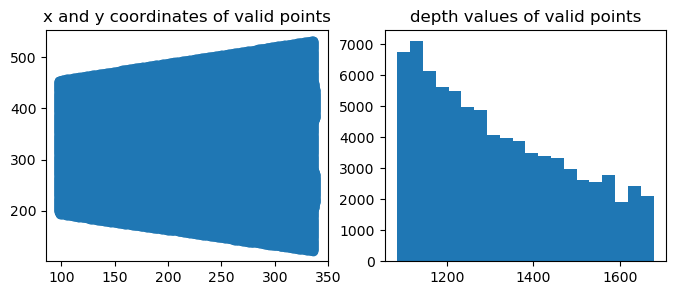

In [107]:
valid_coords = np.argwhere(mask)

# also get the depth values for these points
d = depth[valid_coords[:, 0], valid_coords[:, 1]]

# 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# scatter of x and y coordinates of valid points
ax[0].scatter(valid_coords[:, 0], valid_coords[:, 1])
ax[0].set_title("x and y coordinates of valid points")

# histogram of depth values with 20 bins
ax[1].hist(d, bins=20)
ax[1].set_title("depth values of valid points")
plt.show()

# concatenate coords with depth
valid_coords = np.concatenate([valid_coords, d[:, None]], axis=1)

In [116]:
valid_coords.shape, P.shape

((80520, 3), (3, 4))

In [118]:
points_3d = valid_coords @ P

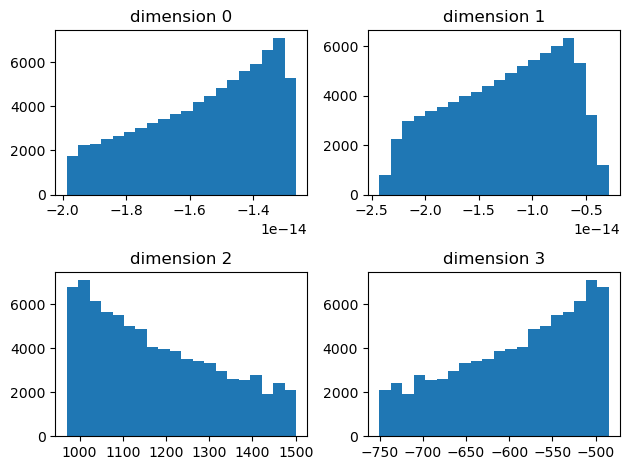

In [124]:
# plot the histogram of each dimension in a 2x2 grid
fig, ax = plt.subplots(2, 2)
axes = ax.flatten()
for i in range(4):
    axes[i].hist(points_3d[:, i], bins=20)
    axes[i].set_title(f"dimension {i}")
plt.tight_layout()
plt.show()

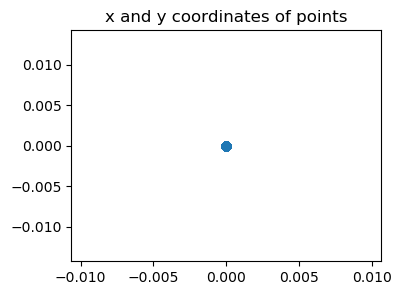

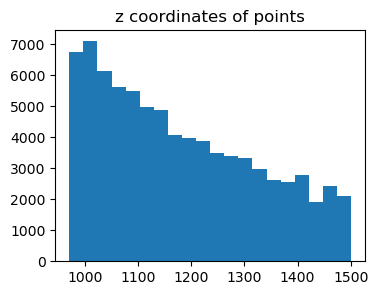

In [125]:
# now we can use the projection matrix to get the 3D points
# we need to solve for
points_3d = valid_coords @ P

# scatter plot of x and y coordinates
plt.figure(figsize=(4, 3))
plt.scatter(points_3d[:, 0], points_3d[:, 1])
plt.title("x and y coordinates of points")
plt.show()

# histogram of the z coordinates
plt.figure(figsize=(4, 3))
plt.hist(points_3d[:, 2], bins=20)
plt.title("z coordinates of points")
plt.show()